<a href="https://colab.research.google.com/github/jrastinejad/CIERA-HS-Program/blob/master/SGRB_Afterglows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Short Gamma-Ray Burst Afterglow Fitting

In [1]:
# Loading some packages to get us started

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.ascii as ascii
from astropy import cosmology
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

# Introduction

---



## Gamma-Rays

Consider the electromagnetic spectrum:

see (/content/img/spectrum.jpg)

On the far right end of the spectrum, we see radio waves. Radio waves are at the lowest energy end of the spectrum. As we move across the spectrum to the left, we increase in energy and frequency. Visible light appears near the middle of the spectrum. Gamma-rays are the highest energy class of light and are only produced on Earth by high energy processes like fusion or gamma decay.

---



## Gamma-Ray Bursts

In the 1960s, astronomers started detecting bursts of gamma-ray emission. The high energy flashes did not repeat and were randomly scattered across the sky. After much work, astronomers realized that these bursts of gamma-rays were coming from other galaxies. To produce the high energy $\textbf{photons}$ (packets of light) that make up gamma-ray bursts (GRBs) a source with a lot of energy is needed! All of these clues led astronomers to believe that are the result of explosions in our universe.

GRBs are not $\textbf{isotropic}$ (spherically symmetric). In fact, much of the explosion's energy is focused along the two poles. The beam that the gamma-rays are accelerated along is referred to as the $\textbf{jet}$. The structure of the explosion means that in order to detect a GRB we must be directly in the path of the GRB.

see (/content/img/grbjets.jpg)

# Exercise 1

## Short vs. Long Gamma-Ray Bursts (GRBs)

It became clear that there were two populations of GRBs - those with short durations and long durations. Below, we will plot the durations of GRBs discovered by the space telescope $\textit{Swift}$ from January 2004 to January 2020. Your job is to run the two cells below, examine the plot and choose a cutoff between short and long duration GRBs.

In [7]:
# data file includes a list of GRBs and the duration of the burst, T90
swift_cat = ascii.read('t90.txt')

# T90 is the amount of time for 90% of the burst's light to be absorbed
t90 = swift_cat['T90']

# If you print the list of GRB names, you'll see that each GRB is named by the date
# it was detected on.
grb_name = swift_cat['GRBname']

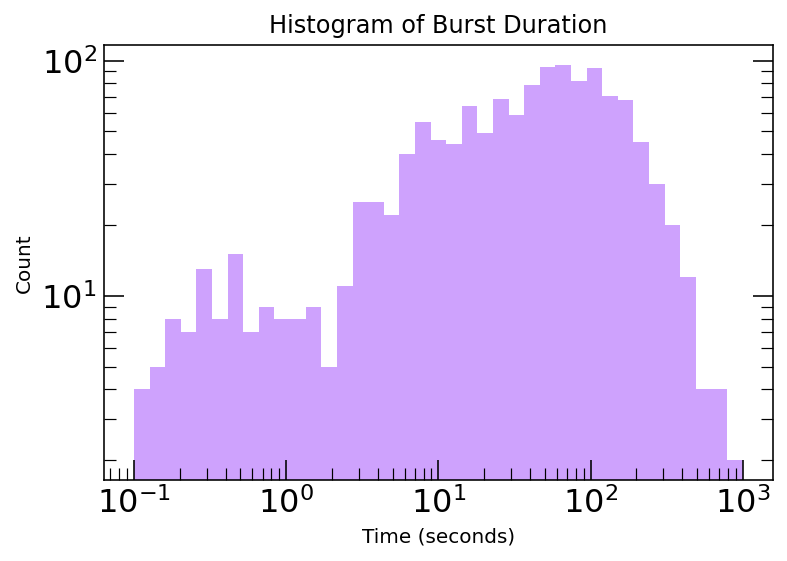

In [8]:
b=np.logspace(-1,3,40)
plt.hist(t90,b,color='xkcd:lilac')
plt.loglog()
plt.tick_params(direction = 'in', length = 10, labelsize = 16, right = True)
plt.tick_params(which = 'minor', direction = 'in', length = 6,  right = True)
plt.xlabel('Time (seconds)')
plt.ylabel('Count')
plt.title('Histogram of Burst Duration')
plt.show()

#### Question 1: Looking at the plot, are you convinced that there are two distinct populations of GRBs? Why?

Answer: 

#### How many seconds would you choose as a cutoff between short and long GRBs? Keep in mind that the axes are in 'log' units.

Answer:

In reality, we use a few other parameters to classify GRBs as short or long. However, duration of the burst is still a useful tool to classify GRBs.

For this project, we will be focusing on short gamma-ray bursts.

## Gamma-Ray Burst Afterglows

Accompanying each GRB is a multiwavelength afterglow. Afterglows as produced by fast-moving ejecta from the explosion colliding with gas that exists in the space between stars. The relativistic (aka VERY fast) collisions between the ejecta and the gas produce what is called $\textbf{synchrotron emission}$. Though we won't go into the mechanics of synchrotron emission here, it's important to know that it creates a $\textbf{jetted multiwavelength afterglow}$. Below is a diagram of an top hat afterglow. In the far right part of the diagram, you see the explosion (jet) colliding with the gas (ambient medium) to produce an afterglow.

see (/content/img/agjet.jpg)

Studying observations of GRB afterglows can teach us about the properties of the burst, including how dense the environment around the explosion is. Below are answers to questions you may have as you simulate afterglow lightcurves.

#### 1. What does multiwavelength mean?
Multiwavelength means that light is emitted in more than one part of the electromagnetic spectrum (see the first figure!). An afterglow emits in the radio, the visible (hereafter called "optical") and the X-ray.

Identifying the multiwavelength components of the afterglow is important because our X-ray, optical and radio detectors are better at localizing sources than gamma-ray detectors. A better localization allows astronomers to study the host environment of the burst and build a better understanding of what precipitated the explosion.

#### 2. What is a lightcurve?
A lightcurve is a plot of time (x-axis) vs brightness (y-axis). Lightcurves are a ubiquitous tool for studying time-domain astronomy. A lightcurve shows us if a source dims, brightens, or stays the same over time. For a steady source like a galaxy, a lightcurve will be flat. A supernova's lightcurve will rise quickly and then fall over time. The lightcurve of a variable star (a star which brightens and dims periodically) will look like this:

see (/content/img/varistarLC.jpg)

Short GRB afterglow lightcurves are most like supernova lightcurves.

#### 3. What is a jet and why is it important?

A jet is a collimated source of relativistic emission. Among other things, a jet is characterized by it's opening angle and shape.

Both the shape and the opening angle of the jet determine if the afterglow will be detectable to an $\textbf{off-axis}$ (not directly in the path of the jet) observer.

#### 4. What does an afterglow jet look like?

Good question! The short answer is that astronomers don't know for sure yet but have many theories. The simulations we'll be using below allow the user to try out a few different jet shapes. These jet shapes include:

$\textbf{Top Hat Jet}$: flux concentrated equally across a narrow beam, outside of which no flux escapes.

$\textbf{Gaussian Jet}$: Similar to a top hat jet except a greater amount of flux is concentrated in the center of the beam.

$\textbf{Power Law Jet}$: Flux concentrated in the middle of the jet but decays as you move to larger viewing angles.


## Using $\texttt{afterglowpy}$

We'll be using the Python package $\texttt{afterglowpy}$ (Ryan et al. 2015, Ryan et al. 2019) to simulate multiwavelength afterglow (AG) lightcurves and match them to actual observations.

From https://github.com/geoffryan/afterglowpy/blob/master/README.md:


jetType can be:
1. -1 (Top Hat)
2. 0 (Gaussian)
3. 1 (Power Law w/ core)
4. 2 (Gaussian w/ core)
5. 3 (Cocoon)
6. 4 (Smooth Power Law).


# Exercise 2a)

The first three cells are mostly complete and will produce an optical Top Hat jet AG lightcurve plot. Using these cells as an example, produce a AG lightcurves for a Gaussian Jet and a Smooth Power Law Jet.

In [4]:
# in order to do run the cells below, uncomment these two lines, run this cell, and then 
# recomment since you only have to do it once!

!pip install afterglowpy 

import afterglowpy as grb

  Created wheel for afterglowpy: filename=afterglowpy-0.6.5-cp36-cp36m-linux_x86_64.whl size=140081 sha256=69719bb57b91559a25c39215c68b0daba8bb1e83811fb18c62fb5d8d01f7c33d
  Stored in directory: /root/.cache/pip/wheels/b2/92/96/3518cefbba3bd3b10bc06827a7550afc992180ea44fd93a126
Successfully built afterglowpy


In [5]:
# Example based on Github code by Geoff Ryan (github.com/geoffryan/afterglowpy/)

# JET PARAMETERS:

thetaObs = 0.05  # Viewing angle in radians
E0 = 1.0e51     # Isotropic-equivalent energy in erg
thetaC = 0.2    # Half-opening angle in radians, range of 0.015 - 0.021 radians
thetaW = 0.1     # Truncation angle, unused for top-hat
b = 0.01           # power law index, unused for top-hat
n0 = 1.0         # circumburst density in cm^{-3}
p = 2.2          # electron energy distribution index
eps_e = 0.1      # epsilon_e
eps_B = 0.01     # epsilon_B
xi_N = 1.0       # Fraction of electrons accelerated
specType = 0 # global cooling time, no inverse compton
q = 0 # keep as 0
ts = 0 # keep as 0
z = 0.356         # redshift, keep this

dist = cosmo.luminosity_distance(z) # outputs distances in Mpc, keep this
dL = dist.value * 3.086e24 # Luminosity distance of burst in cm, keep this

Choose time range
Calculate Top Hat Jet
Plot!


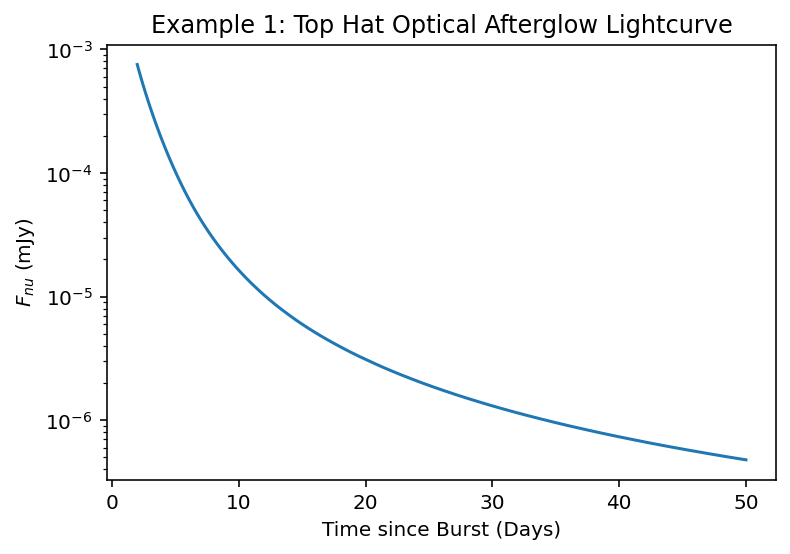

In [6]:
# creating a grid of times for the x-axis of our afterglow lightcurves

print("Choose time range")

ta = 2.0 * grb.day2sec
tb = 50 * grb.day2sec
tsec = np.geomspace(ta, tb, num=100)

# Calculate flux in a single optical band (all times have same frequency)
nu = np.empty(tsec.shape)
nu[:] = 4.8e14

# For convenience, place positional arguments in an array and keywords into a dict

Y = np.array([thetaObs, E0, thetaC, thetaW, b, specType, q, ts, n0, p, eps_e, eps_B, xi_N, dL])
Z = {'z': z}

# Calculate!

jetType_top = -1     # top hat jet

print("Calculate Top Hat Jet")
Fnu_top = grb.fluxDensity(tsec, nu, jetType_top, 0, *Y, **Z)

# Change time units back to days

t = tsec * grb.sec2day

# Plot!
print("Plot!")

plt.plot(t,Fnu_top)
plt.yscale('log')
plt.xlabel('Time since Burst (Days)')
plt.ylabel(r'$F_{nu}$ (mJy)')
plt.title('Example 1: Top Hat Optical Afterglow Lightcurve')
plt.show()

# Exercise 2b

Calculate Top Hat, Gaussian and Power Law jet afterglow lightcurves.

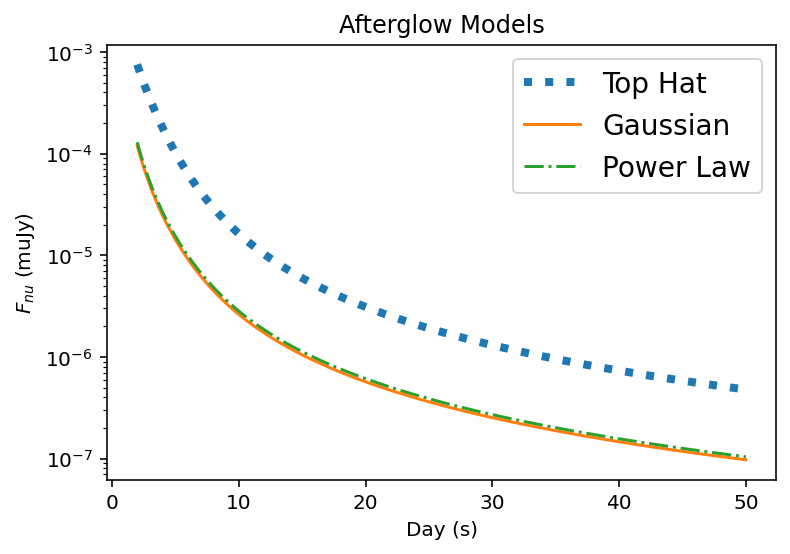

In [ ]:
# Set up array of relevant times
ta = 2.0 * grb.day2sec
tb = 50.0 * grb.day2sec
tsec = np.geomspace(ta, tb, num=100)

# Calculate flux in a single optical band (all times have same frequency)

nu = np.empty(tsec.shape)
nu[:] = 4.8e14 # approximate r-band frequency

# recall number that corresponds to Gaussian jet
jetType_gau = 

# recall number that corresponds to Power Law jet
jetType_pl = 

# Calculate the brightness of your jet!

print('Calculate Top Hat Jet')
Fnu_top = grb.fluxDensity() # fill in
print('Calculate Gaussian Jet')
Fnu_gau = grb.fluxDensity() # fill in
print('Calculate Power Law Jet')
Fnu_pl = grb.fluxDensity() # fill in

# change time back to days

t = tsec * grb.sec2day

print("Plot!")

plt.plot(t,Fnu_top, ls = ':', lw=4, label = 'Top Hat') # fill in label
plt.plot(t,Fnu_gau, label = 'Gaussian') # fill in label
plt.plot(t,Fnu_pl, ls = '-.', label = 'Power Law') # fill in label
plt.yscale('log')
plt.xlabel('Days since burst') # fill in
plt.ylabel(r'$F_{nu}$ (muJy)') # fill in
plt.title('Afterglow Models')
plt.legend(fontsize=14)
plt.show()

# Exercise 3a

Replot your four afterglows from Exercise 2 with the real optical afterglow dataset of the SGRB 130603B. Determine which afterglow jet model best fits the data. Explain why in the cell below.

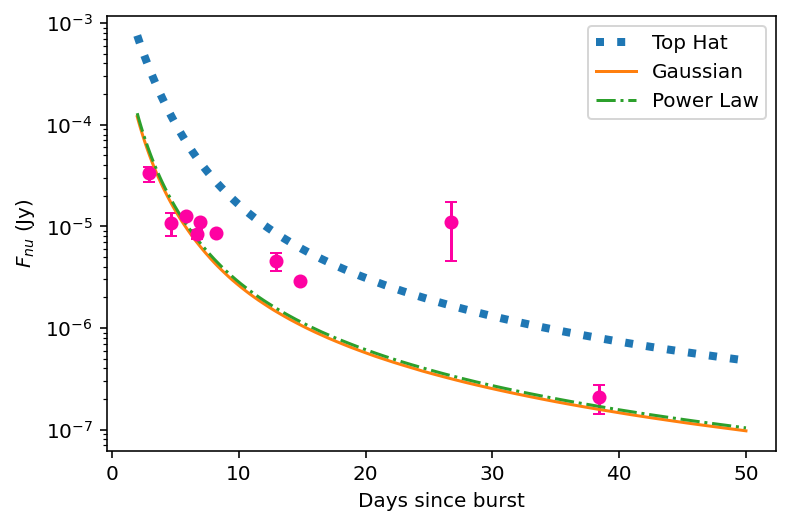

In [ ]:
# Load in SGRB 130603B dataset

obs = np.loadtxt('130603b_OmuJy.txt')

time = obs[:,0]
filt = obs[:,2]
flux = obs[:,3]
ferr = obs[:,4]
det = obs[:,5]

# Add condition to only choose points at a certain wavelengths where something was detected

cond = (filt > 0.5) & (filt < 0.7) & (det == 1)

time=time[cond]
fil = filt[cond]
fl = flux[cond] * 1e-6 # convert micro-Jansky to Jansky to match model units
flerr = ferr[cond] * 1e-6 # convert micro-Jansky to Jansky

# Plotting the data with error bars

plt.errorbar(time,fl,yerr=flerr,capsize=3,fmt='o',color='xkcd:shocking pink')

# Re-plot your Top Hat, Gaussian, Power Law and Gaussian w/ core afterglow models

plt.plot(t, , ls = ':',lw=4, label = 'Top Hat') # fill in
plt.plot(t, , label = 'Gaussian') # fill in 
plt.plot(t, , ls = '-.', label = 'Power Law') # fill in
plt.yscale('log')

plt.xlabel('Days since burst')
plt.ylabel(r'$F_{nu}$ (Jy)')
plt.legend()
plt.show()

#### Question: Which jet type(s) fit the optical afterglow of GRB 130603B the best?

Answer:

## Exercise 3a Challenge: Choose the model you think fits the data best and adjust the jet parameters (what goes into Y) to determine the best fit by eye.

Recommended: E0, thetaC, thetaW. Try it below and record your best fits to the data.

In [ ]:
thetaObs = 0.0  # Viewing angle in radians
E0 = 1.0e53      # Isotropic-equivalent energy in erg
thetaC = 0.1     # Half-opening angle in radians
thetaW = 0.1     # Truncation angle, unused for top-hat
b = .01            # power law index, unused for top-hat
n0 = 1.0         # circumburst density in cm^{-3}
p = 2.2          # electron energy distribution index
eps_e = 0.1      # epsilon_e
eps_B = 0.01     # epsilon_B
xi_N = 1.0       # Fraction of electrons accelerated
specType = 0 # global cooling time, no inverse compton

# repeat process to get new lightcurves



# plot




# Exercise 4

Now determine the best energy fit value for SGRB 090510.

In [ ]:
thetaObs = 0.05  # Viewing angle in radians
E0 = # choose     # Isotropic-equivalent energy in erg
thetaC = 0.1     # Half-opening angle in radians
thetaW = 0.1     # Truncation angle, unused for top-hat
b = .01            # power law index, unused for top-hat
n0 = 1.0         # circumburst density in cm^{-3}
p = 2.2          # electron energy distribution index
eps_e = 0.1      # epsilon_e
eps_B = 0.01     # epsilon_B
xi_N = 1.0       # Fraction of electrons accelerated

In [ ]:
# Load in SGRB 090510 dataset (see 130603B for example)

obs = np.loadtxt('090510_OmuJy.txt')

time = obs[:,0]
filt = obs[:,1]
flux = obs[:,2]
ferr = obs[:,3]
det = obs[:,4]

cond = 

time =
fil = 
fl = 
flerr = 

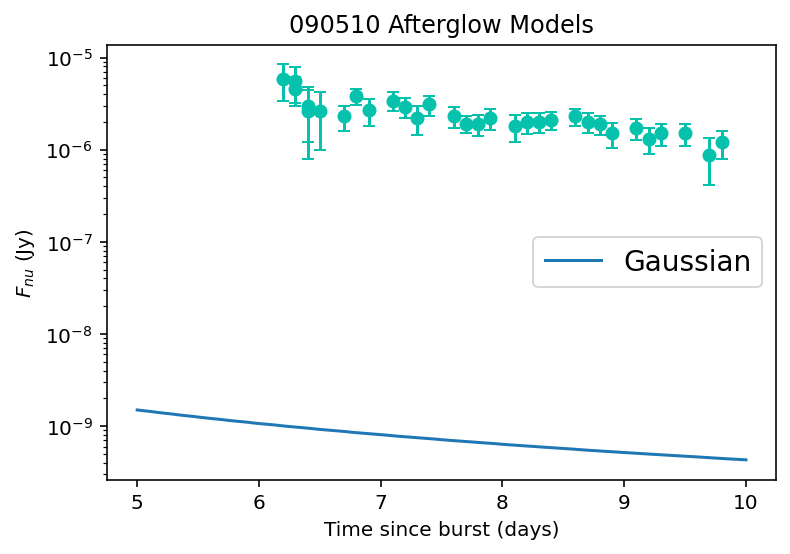

In [ ]:
# Choose time range

ta = grb.day2sec * # choose lower time
tb = grb.day2sec * # choose upper time
tsec = np.geomspace() # write

print('Time range chosen')

# Calculate flux in a single optical band (all times have same frequency)

nu = np.empty(tsec.shape)
nu[:] = 4.8e14 # approximate r-band frequency

Y = np.array([thetaObs, E0, thetaC, thetaW, b, specType, q, ts, n0, p, eps_e, eps_B, xi_N, dL])
Z = {'z': z}

# Calculate!

Fnu_gau = 

print("Calculated Gaussian Jet flux")

# Convert time back to days and plot!

t = 

print("Plot Observed Data")

plt.errorbar(time,fl,yerr=flerr,capsize=3,fmt='o',color='xkcd:shocking pink')

print("Plot Models")

plt.plot(t,Fnu_gau, label = 'Gaussian')
plt.yscale('log')
plt.xlabel('Time since burst (days)')
plt.ylabel(r'$F_{nu}$ (Jy)')
plt.title('090510 Afterglow Models')
plt.legend(fontsize=14)
plt.show()

# Exercise 4

## Creating multiwavelength afterglow lightcurves

SGRB 050724 was the first short gamma-ray burst whose afterglow was detected in the X-ray, optical, near-infrared and radio parts of the EM spectrum. As time went by, astronomers started sampling the afterglows more frequenctly across wavelengths. Here, we will compare the multiwavelength observations from the 130603B with our lightcurves for different jet types. Data from Table 1, Fong, Berger, Metzger et al. 2013 (https://iopscience.iop.org/article/10.1088/0004-637X/780/2/118/pdf).

## Unit conversions

In order to produce lightcurves in the correct units, we must provide the models with the correct units of frequency, $\nu$. We can calculate $\nu$ from wavelength $\lambda$ by:

\begin{equation}
c = \lambda * \nu
\end{equation}

Where $c$ is the speed of light ($c=3*10^{10}$ cm/s), $\nu$ is frequency, and $\lambda$ is wavelength.

Below is the electromagnetic spectrum with approximate values for $\lambda$. As $\texttt{afterglowpy}$ only accepts $\nu$ values, you'll need to convert to frequency to calculate your multiwavelength afterglow lightcurves. Below is an EM spectrum with frequency and wavelength so you can check you have approximately the correct values. However, I'll give you the exact wavelength values below to calculate.

see (/content/img/emspectrum_nu.png)

# Part 4a) 

Calculating frequency of each band

In [ ]:
# calculate X-ray, optical, near infrared and radio frequencies in Hz given 

c = 3e10 # units = cm/s

lambda_xray = 1.24e-3 # cm units
nu_xray = 

lambda_opt = 0.62e-4 # cm units
nu_opt = 

lambda_nir = 1.2e-4 # cm units
nu_nir = 

lambda_rad = 4.5e4 # cm units
nu_rad = 

In [ ]:
# Preliminary Jet parameters - leave for now, can play with later!

thetaObs = 0.05  # Viewing angle in radians
E0 = 1.0e51    # Isotropic-equivalent energy in erg
thetaC = 0.1     # Half-opening angle in radians
thetaW = 0.1     # Truncation angle, unused for top-hat
b = .01            # power law index, unused for top-hat
n0 = 1.0         # circumburst density in cm^{-3}
p = 2.2          # electron energy distribution index
eps_e = 0.1      # epsilon_e
eps_B = 0.01     # epsilon_B
xi_N = 1.0       # Fraction of electrons accelerated
specType = 0 # global cooling time, no inverse compton

# Part 4b) 

Load in observed multiwavelength data and sort it part filter (X-ray, Optical, Near-Infrared, and Radio) by detection (q = 1) or upper limit (q = 0). Upper limits can be useful because they can help us rule out models that are too bright.

In [ ]:
# Load in data

obs = np.loadtxt('multiwave_OmuJy.txt')

dt = obs[:,0] # time in days
filt = obs[:,1] # filter in microns (1 micron = 10000 centimeters)

print(filt) # print to see which part of the spectrum the data was taken at

flux = obs[:,2] # flux in microJansky
ferr = obs[:,3] # flux error in microJansky

q = obs[:,4] # detection = 1, upper limit = 0

# Separate data by filter and if detection or upper limit




# Part 4c)

Create multiwavelength models using frequencies calculated in Part 4a) and plot with observations.

In [ ]:
# Choose appropriate time range

ta = grb.day2sec * # choose lower time
tb = grb.day2sec * # choose upper time
tsec = np.geomspace() # write

# calculate multiwavelength lightcurves

print("Calc Radio")
FnuR = grb.fluxDensity()
print("Calc Optical")
FnuO = grb.fluxDensity()
print("Calc Near Infrared")
FnuN = grb.fluxDensity()
print("Calc X-ray")
FnuX = grb.fluxDensity()

# plot data by filter - make sure to use different markers for detections and upper limits




# plot models

print("Plot")

t = 

plt.plot(t,FnuR, label = 'Radio')
plt.plot(t,FnuO, label = 'Optical')
plt.plot(t,FnuN, label = 'Near-Infrared')
plt.plot(t,FnuX, label = 'X-ray')

plt.yscale('log')
plt.xlabel('') # add in
plt.ylabel(r'') # add in
plt.title('') # add in
plt.legend(fontsize=14)
plt.show()

SyntaxError: invalid syntax (<ipython-input-56-358c267fe093>, line 9)

# Part 4d)

Play with your Jet parameters and jetType to get the best fit to all of the detections and upper limits.

In [ ]:
# Work space for 4d

#### Question: Which jet type fits the data best?

Answer:

# Nice job!

If you finished early, here's a challenge:

We have been determining the best models by eye for these exercises. However, in practice astronomers like to use statistics to make sure we are finding the best fit. To do this, we must:

1. Determine how to quantitatively measuring how good a fit is
2. Minimize or maximize this quantity to make sure we have the best fit possible
 
Feel free to ask more questions! I'm happy to help provide resources for smart ways to do this.